In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess the data
df = pd.read_csv('../data/mulu/mulu-rainfall-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)
df.drop(columns=["TOTAL", "ClimAdjust", "Latitude", "Longitude", "Elevation"], inplace=True)

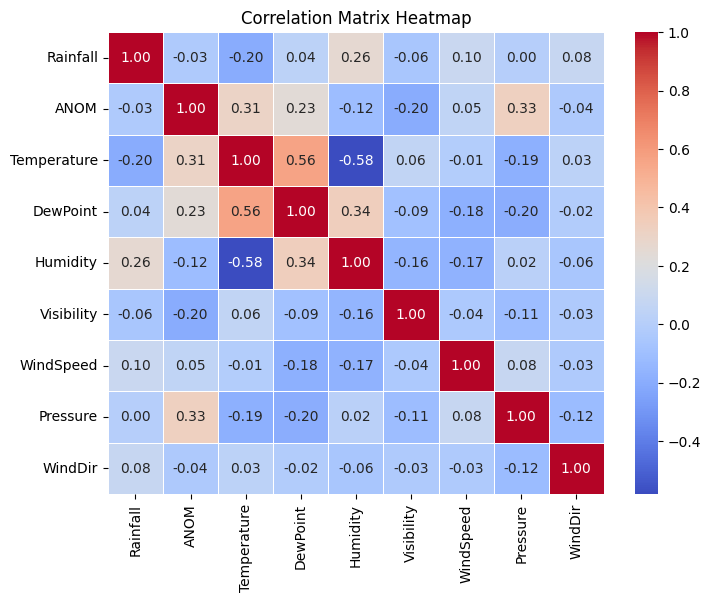

In [2]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [3]:
df

,Rainfall,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,,,
2010-11-26,16.0,-1.64,81.090909,74.909091,82.409091,6.000000,5.909091,29.668182,224.000780
2010-11-27,16.0,-1.64,79.875000,74.416667,84.500000,6.000000,5.750000,29.683750,57.239884
2010-11-28,8.0,-1.64,80.826087,76.130435,86.217391,6.000000,4.173913,29.671739,27.028382
2010-11-29,11.5,-1.64,81.125000,76.666667,86.750000,6.000000,4.708333,29.637500,275.746991
2010-11-30,17.5,-1.64,78.181818,75.545455,91.954545,5.681818,5.590909,29.619091,166.150255
...,...,...,...,...,...,...,...,...,...
2019-12-27,3.4,0.52,80.208333,78.416667,94.375000,5.708333,3.500000,29.756250,16.924704
2019-12-28,3.0,0.52,79.541667,77.666667,93.791667,5.458333,4.041667,29.748750,59.331488
2019-12-29,0.8,0.52,83.125000,78.916667,87.041667,6.000000,5.458333,29.740000,46.601550


In [4]:
# temporal features
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day_of_Year'] = df.index.dayofyear

def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df = cyclical_encode(df, 'Month', 12)
df = cyclical_encode(df, 'Day_of_Week', 7)
df = cyclical_encode(df, 'Day_of_Year', 366)
df.drop(['Month','Day_of_Week','Day_of_Year'], axis=1,inplace=True)

print(df.columns.to_list())
print(f"columns length after temporal features: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos']
columns length after temporal features: 15


In [5]:
# Define feature groups
interaction_features = {
    'Rainfall': ['Temperature', 'Humidity', 'Visibility', 'WindDir'],
    'Temperature': ['DewPoint', 'Humidity', 'Visibility', 'Pressure'],
    'Humidity': ['DewPoint', 'WindSpeed', 'WindDir'],
    'Visibility': ['WindSpeed', 'WindDir'],
    'WindDir': ['WindSpeed']
}

# Create interaction features
for feature, correlated_features in interaction_features.items():
    for correlated_feature in correlated_features:
        interaction_term = f'{feature}_{correlated_feature}'
        df[interaction_term] = df[feature] * df[correlated_feature]

df['Rainfall_Temperature_Humidity'] = df['Rainfall'] * df['Temperature'] * df['Humidity']
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Rainfall_Temperature', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindDir', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_Pressure', 'Humidity_DewPoint', 'Humidity_WindSpeed', 'Humidity_WindDir', 'Visibility_WindSpeed', 'Visibility_WindDir', 'WindDir_WindSpeed', 'Rainfall_Temperature_Humidity']
columns length after interaction: 30


In [6]:
df['DewPoint_Depression'] = df['Temperature'] - df['DewPoint']
df['WindDir_u'] = np.cos(np.radians(df['WindDir']))
df['WindDir_v'] = np.sin(np.radians(df['WindDir']))
df['Humidity_Pressure_Index'] = df['Humidity'] * (1/df['Pressure'])

In [7]:
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Rainfall_Temperature', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindDir', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_Pressure', 'Humidity_DewPoint', 'Humidity_WindSpeed', 'Humidity_WindDir', 'Visibility_WindSpeed', 'Visibility_WindDir', 'WindDir_WindSpeed', 'Rainfall_Temperature_Humidity', 'DewPoint_Depression', 'WindDir_u', 'WindDir_v', 'Humidity_Pressure_Index']
columns length after interaction: 34


In [8]:
for feat in ['Rainfall', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure']:
    for window in [3, 7]:
        df[f"{feat}_{window}d_avg"] = df[feat].rolling(window).mean()
        df[f"{feat}_{window}d_std"] = df[feat].rolling(window).std()
        df[f"{feat}_{window}d_sum"] = df[feat].rolling(window).sum()
        df[f"{feat}_{window}d_min"] = df[feat].rolling(window).min()
        df[f"{feat}_{window}d_max"] = df[feat].rolling(window).max()
        df[f"{feat}_{window}d_median"] = df[feat].rolling(window).median()

df.dropna(inplace=True)
print(f"columns length after rolling statistics: {df.columns.size}")

columns length after rolling statistics: 118


C:\Users\User\AppData\Local\Temp\ipykernel_23992\2256657539.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feat}_{window}d_sum"] = df[feat].rolling(window).sum()
C:\Users\User\AppData\Local\Temp\ipykernel_23992\2256657539.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feat}_{window}d_min"] = df[feat].rolling(window).min()
C:\Users\User\AppData\Local\Temp\ipykernel_23992\2256657539.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [9]:
# Define features and target
target = 'Rainfall'
features = [col for col in df.columns if col != target]

# for feature in ['Temperature', 'Humidity', 'Pressure', 'WindSpeed', 'WindDir', 'Visibility', 'DewPoint']:
for feature in features:
    # Create all lag features for the current variable
    for i in range(1, 8):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

df.dropna(inplace=True)
print(f"columns length after lagged features: {df.columns.size}")

C:\Users\User\AppData\Local\Temp\ipykernel_23992\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_23992\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_23992\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

columns length after lagged features: 937


C:\Users\User\AppData\Local\Temp\ipykernel_23992\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_23992\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_23992\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [10]:
# Get the number of null values for each column and sort them in descending order
null_counts = df.isna().sum().sort_values(ascending=False)

# Filter only columns that have null values (count > 0)
null_counts = null_counts[null_counts > 0]

if len(null_counts) > 0:
    print("Columns with null values:")
    print(null_counts)
else:
    print("No null values found in the dataset")

No null values found in the dataset


In [11]:
# Split the data
X = df[features]
y = df[target]

# Split into train and test sets
train_size = int(len(df) * 0.7)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale the data using RobustScaler
scaler_X = RobustScaler()
scaler_y = PowerTransformer(method='yeo-johnson')
# scaler_y = RobustScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
    ])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

# Train model
history = model.fit(
    X_train_reshaped, 
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

d:\rainfall-forecast\lstm\.virt\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       125,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,001 (750.00 KB)

 Trainable params: 192,001 (750.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.9437 - val_loss: 0.5018
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4311 - val_loss: 0.1423
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1789 - val_loss: 0.0899
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1141 - val_loss: 0.0792
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0855 - val_loss: 0.0606
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0682 - val_loss: 0.0707
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0592 - val_loss: 0.0648
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0635 - val_loss: 0.0457
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0473 - val_loss: 0.0367
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0454 - val_loss: 0.0276
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0449 - val_loss: 0.0379
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
MAE (Train): 2.70959686293391
MSE (Train): 54.62014567931927
R2 (Train): 0.8518402268123628


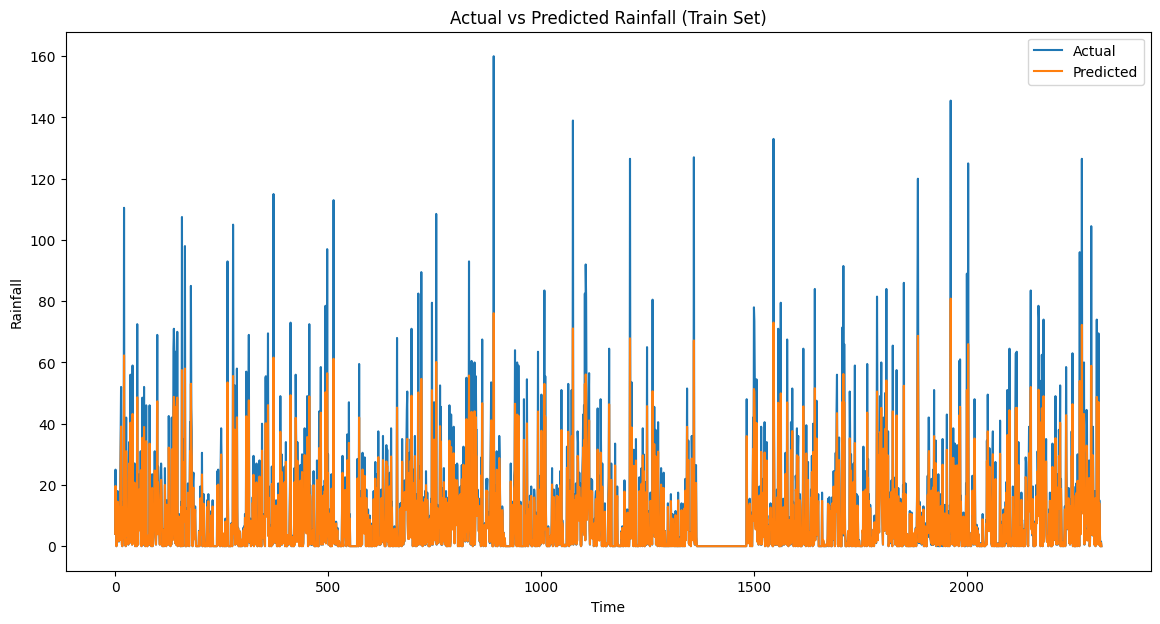

In [12]:
# Predict on the training set
y_train_pred_scaled = model.predict(X_train_reshaped)

# Inverse transform the scaled predictions and actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train_scaled)

# get the sample data into a dataframe
df_results = pd.DataFrame(y_train_actual, columns=['actual'])
df_results['predicted'] = y_train_pred

# Calculate evaluation metrics
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mse_train = mean_squared_error(y_train_actual, y_train_pred)    
r2_train = r2_score(y_train_actual, y_train_pred)
print(f'MAE (Train): {mae_train}')
print(f'MSE (Train): {mse_train}')
print(f'R2 (Train): {r2_train}')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_train_actual, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Actual vs Predicted Rainfall (Train Set)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

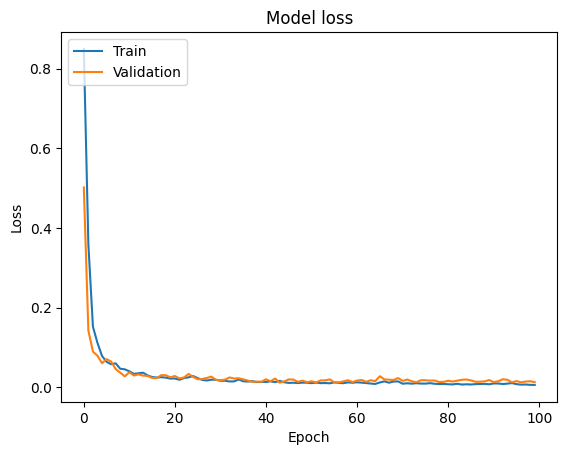

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
print(df_results.describe())
print(df.shape)

            actual    predicted
count  2317.000000  2317.000000
mean     11.566034     8.907716
std      19.204589    12.844984
min       0.000000    -0.009797
25%       0.000000     0.010819
50%       3.000000     3.077870
75%      15.500000    13.511711
max     160.000000    80.855026
(3310, 937)


In [15]:
model.save('LSTM_model1.h5')